In [ ]:
import kagglehub
path = kagglehub.dataset_download("banudeep/nthuddd2")

100%|██████████| 2.81G/2.81G [00:18<00:00, 161MB/s]

Extracting files...


In [ ]:
print(path)
!ls  /root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1

/root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1
train_data


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torchvision.models import convnext_tiny


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data preprocessing ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder("/root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1/train_data", transform=transform)

# --- Split the dataset ---
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"{train_size} :  {val_size} : {test_size}")

model = convnext_tiny(pretrained=True)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)# 2 classes: drowsy and not drowsy


if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / total)

    torch.save(model.state_dict(), f"drowsy_densenet_epoch_{epoch+1}.pth")

    model.eval()
    val_loss, val_correct = 0, 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

            val_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / len(val_loader.dataset))

    test_correct, test_total = 0, 0
    test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Testing]")
    with torch.no_grad():
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            test_bar.set_postfix(accuracy=100 * test_correct / test_total)

    test_acc = 100 * test_correct / test_total

    print(f"Epoch {epoch+1}/{epochs} Summary --> "
          f"Train Acc: {100 * train_correct / total:.2f}%, "
          f"Val Acc: {100 * val_correct / len(val_loader.dataset):.2f}%, "
          f"Test Acc: {test_acc:.2f}%")

46564 :  9978 : 9979


Epoch 1/10 [Testing]: 100%|██████████| 312/312 [00:56<00:00,  5.51it/s, accuracy=54.1]


Epoch 1/10 Summary --> Train Acc: 53.56%, Val Acc: 54.89%, Test Acc: 54.06%


Epoch 2/10 [Testing]: 100%|██████████| 312/312 [00:57<00:00,  5.42it/s, accuracy=93.6]


Epoch 2/10 Summary --> Train Acc: 74.71%, Val Acc: 93.60%, Test Acc: 93.61%


Epoch 3/10 [Testing]: 100%|██████████| 312/312 [00:58<00:00,  5.37it/s, accuracy=95.3]


Epoch 3/10 Summary --> Train Acc: 95.03%, Val Acc: 95.17%, Test Acc: 95.27%


Epoch 4/10 [Testing]: 100%|██████████| 312/312 [00:56<00:00,  5.55it/s, accuracy=97.9]


Epoch 4/10 Summary --> Train Acc: 97.06%, Val Acc: 97.79%, Test Acc: 97.90%


Epoch 5/10 [Testing]: 100%|██████████| 312/312 [00:57<00:00,  5.43it/s, accuracy=98.4]


Epoch 5/10 Summary --> Train Acc: 97.90%, Val Acc: 98.39%, Test Acc: 98.37%


Epoch 6/10 [Testing]: 100%|██████████| 312/312 [00:56<00:00,  5.55it/s, accuracy=98.7]


Epoch 6/10 Summary --> Train Acc: 98.19%, Val Acc: 98.86%, Test Acc: 98.75%


Epoch 7/10 [Testing]: 100%|██████████| 312/312 [00:57<00:00,  5.39it/s, accuracy=98.9]


Epoch 7/10 Summary --> Train Acc: 98.48%, Val Acc: 99.00%, Test Acc: 98.95%


Epoch 8/10 [Testing]: 100%|██████████| 312/312 [00:56<00:00,  5.52it/s, accuracy=98.6]


Epoch 8/10 Summary --> Train Acc: 98.68%, Val Acc: 98.41%, Test Acc: 98.63%


Epoch 9/10 [Testing]: 100%|██████████| 312/312 [00:56<00:00,  5.53it/s, accuracy=98.6]


Epoch 9/10 Summary --> Train Acc: 98.83%, Val Acc: 98.80%, Test Acc: 98.60%


Epoch 10/10 [Testing]: 100%|██████████| 312/312 [00:56<00:00,  5.52it/s, accuracy=99.3]

Epoch 10/10 Summary --> Train Acc: 98.84%, Val Acc: 99.13%, Test Acc: 99.26%


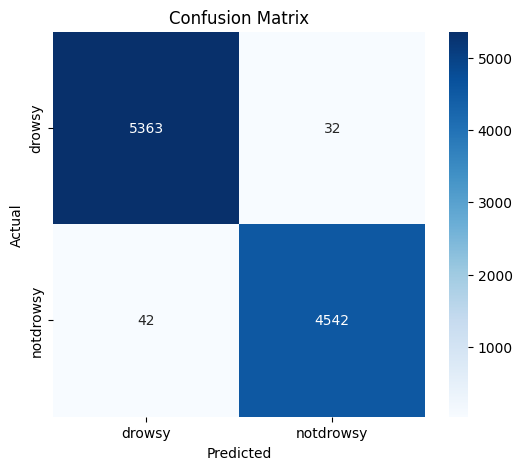


Classification Report:
              precision    recall  f1-score   support

      drowsy       0.99      0.99      0.99      5395
   notdrowsy       0.99      0.99      0.99      4584

    accuracy                           0.99      9979
   macro avg       0.99      0.99      0.99      9979
weighted avg       0.99      0.99      0.99      9979



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

target_names = dataset.classes  # e.g., ['drowsy', 'not_drowsy']

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))